# Classificação de documentos para Desambiguação de Nomes de Autores (AND)


### Introdução

Nesse tutorial vamos fazer o fine-tuning de um modelo transformer (BERT) para **Classificação Multiclasse de documentos**.

Vamos utiliza-lo para performar e resolver o problema de Desambiguação de Nomes de Autores (AND) de determinado repositório bibliográfico digital ou dataset.

#### Fluxo do Notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importando Bibliotecas Python e preparando o ambiente](#section01)
2. [Importando e Pré-processando os dados do domínio](#section02)
3. [Preparando o Conjunto de Dados e o Carregador de Dados](#section03)
4. [Criando a Rede Neural para Ajuste Fino](#section04)
5. [Fine Tuning e ajuste do Modelo](#section05)
6. [Validando o Desempenho do Modelo](#section06)
7. [Salvando o modelo e artefatos para Inferência Futura](#section07)



#### Detalhes técnicos

Este script utiliza várias ferramentas projetadas por outras equipes. Detalhes das ferramentas utilizadas abaixo. Certifique-se de que esses elementos estejam presentes em sua configuração para implementar com sucesso este script.


Modelo de Linguagem Usado:
- O SciBERT é um modelo de linguagem baseado em transformers, desenvolvido especificamente para tarefas relacionadas ao domínio científico. Ele utiliza uma arquitetura semelhante ao BERT, porém pré-treinado em uma grande quantidade de texto científico. Algumas características do SciBERT incluem:
- Especialização Científica: O SciBERT é ajustado para entender melhor o vocabulário e a estrutura de documentos científicos, o que o torna mais adequado para tarefas específicas do domínio científico.
- Transferência de Aprendizado: Como parte da família BERT, o SciBERT se beneficia da transferência de aprendizado, onde os conhecimentos adquiridos durante o pré-treinamento podem ser aplicados a tarefas específicas, como classificação de texto, extração de informações, entre outras.
- Desempenho em Tarefas Científicas: Devido à sua especialização, o SciBERT geralmente supera modelos genéricos em tarefas relacionadas ao domínio científico, proporcionando resultados mais precisos e relevantes.

- Recursos adicionais sobre o SciBERT:
	- Postagem no Blog
	- Artigo de Pesquisa
	- Documentação para Python


Dados:

- Estamos utilizando o conjunto de dados AMiner para desambiguação de nomes, disponível no repositório UCI Machine Learning Repository. Este conjunto de dados é usado para resolver o problema de desambiguação de nomes, onde o mesmo nome pode se referir a diferentes pessoas em diferentes contextos. Os pontos de dados incluem:
	- Nome: Nome da pessoa a ser desambiguada.
    - Gênero: Gênero da pessoa (masculino ou feminino).
    - Título do Documento: Título do documento em que o nome ocorre.
    - Resumo: Resumo do documento.
    - Categoria: Categoria do documento.
    - ID do Autor: ID do autor associado ao documento.
    - Conferência: Nome da conferência em que o documento foi apresentado.
    - Ano de Publicação: Ano de publicação do documento.
    - Número de citações: Número de citações recebidas pelo documento.

- Recursos adicionais sobre o conjunto de dados AMiner para desambiguação de nomes:
	- Artigo de Pesquisa -

  Yutao Zhang, Fanjin Zhang, Peiran Yao, and Jie Tang. Name Disambiguation in AMiner: Clustering, Maintenance, and Human in the Loop. In Proceedings of the Twenty-Forth ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD'18).

	- Documentação - https://github.com/neozhangthe1/disambiguation/
  - Download - https://static.aminer.cn/misc/na-data-kdd18.zip




Requisitos de Hardware:
- Python 3.6 e superior
- Pytorch, Transformers e todas as bibliotecas de Machine Learning padrão do Python
- Configuração habilitada para GPU

Objetivo do Script:
- O objetivo deste script é ajustar o SciBERT/BERT para ser capaz de classificar um título e resumos de documentos(publicacões) em classes de autores.

<a id='section01'></a>
### Importando Bibliotecas Python e preparando o ambiente



Nesta etapa, vamos importar as bibliotecas e módulos necessários para executar nosso script. As bibliotecas são:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* SciBERT Model and Tokenizer

Em seguida, vamos preparar o dispositivo para execução do CUDA. Essa configuração é necessária se você quiser aproveitar a GPU embarcada.


In [59]:
# Importando as bibliotecas necessárias
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

In [60]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [61]:
!nvidia-smi

Sat Apr  6 01:48:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              49W / 400W |  19989MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

<a id='section02'></a>
### Importando e pré-processando os dados
- Os dados estão no Google Drive

In [180]:
import os
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

#Nome do autor a ser tratado utilizando o SciBert
autor = 'hongbin liang'
#autor = 'jing luo'

# Definir variável para controlar se deve tratar apenas um autor específico
tratar_apenas_um_autor = False

# Função para ler o CSV contendo os dados das publicações e autores
def read_csv(file_path):
    df = pd.read_csv(file_path, delimiter=';')
    return df

data_dir = "/content/drive/MyDrive/ADAN/fine_tuning_sci_bert/input"

# Caminho para o arquivo CSV gerado a partir dos JSONs
input_csv_file = 'publications_authors.csv'

# Importar o CSV para um dataframe do pandas e adicionar os cabeçalhos
df = read_csv(os.path.join(data_dir, input_csv_file))

if tratar_apenas_um_autor:
    # Filtrar apenas as linhas com autor escolhido. e.g, 'hongbin liang'
    df_autor = df[df['author_name'] == autor]

    # Remover colunas indesejadas e deixar apenas o título da notícia e a categoria que será o alvo
    df_autor = df_autor[['publication_title', 'author_id', 'abstract']]

    # Criar um dicionário para mapear os IDs dos autores para números inteiros
    author_encode_dict = {}

    def encode_author(author_id):
        if author_id not in author_encode_dict:
            author_encode_dict[author_id] = len(author_encode_dict)
        return author_encode_dict[author_id]

    # Aplicar a codificação aos IDs dos autores
    df_autor['ENCODE_AUTHOR'] = df_autor['author_id'].apply(lambda x: encode_author(x))

    num_authors = len(author_encode_dict)

    classes = num_authors
    print("Quantidade de classe de autores: " + str(classes))


    # Verificar a saída
    df_autor.head()

    df = df_autor

    # Imprimir a quantidade de documentos para o autor específico
    print("Quantidade total de documentos: " + str(df.shape[0]))


    df.head()
else:
    # Remover colunas indesejadas e deixar apenas o título da notícia e a categoria que será o alvo
    df_autores = df[['publication_title', 'author_id', 'abstract']]

    # Criar um dicionário para mapear os IDs dos autores para números inteiros
    author_encode_dict = {}

    def encode_author(author_id):
        if author_id not in author_encode_dict:
            author_encode_dict[author_id] = len(author_encode_dict)
        return author_encode_dict[author_id]

    # Aplicar a codificação aos IDs dos autores
    df_autores['ENCODE_AUTHOR'] = df_autores['author_id'].apply(lambda x: encode_author(x))

    num_authors = len(author_encode_dict)

    classes = num_authors
    print("Quantidade de classe de autores: " + str(classes))




    # Verificar a saída
    df_autores.head()

    df = df_autores

    # Imprimir a quantidade de documentos para o autor específico
    print("Quantidade total de documentos: " + str(df.shape[0]))

    df.head()

df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Quantidade de classe de autores: 39655
Quantidade total de documentos: 208827


<ipython-input-180-d212e5f1d9b6>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_autores['ENCODE_AUTHOR'] = df_autores['author_id'].apply(lambda x: encode_author(x))


,publication_title,author_id,abstract,ENCODE_AUTHOR
0,Induced life cycle transition from holocycly t...,5b5433f3e1cd8e4e1516badf,"The Russian wheat aphid (RWA), Diuraphis noxia...",0
1,Impact of alfalfa/cotton intercropping and man...,5b5433f3e1cd8e4e1516badf,A short-term study was carried out to evaluate...,0
2,A check-list of the Chinese Megalopodinae (Col...,5b5433e5e1cd8e4e15f7474c,Two genera and 33 taxa of Megalopodinae are re...,1
3,Key to the species of the genus Aristochroa Ts...,5b5433e5e1cd8e4e15f7474c,A key to all 14 species of Aristochroa Tschits...,1
4,A review of genus Onycholabis bates (Coleopter...,5b5433e5e1cd8e4e15f7474c,Species in the genus Onycholabis Bates are bri...,1


<a id='section03'></a>
### Preparando o Conjunto de Dados e o Carregador de Dados

Vamos começar definindo algumas variáveis-chave que serão usadas posteriormente durante o estágio de treinamento/ajuste fino.
Seguido pela criação da classe Dataset - Isso define como o texto é pré-processado antes de ser enviado para a rede neural. Também vamos definir o Dataloader que irá alimentar os dados em lotes para a rede neural para treinamento e processamento adequados.
Dataset e Dataloader são construções da biblioteca PyTorch para definir e controlar o pré-processamento dos dados e sua passagem para a rede neural. Para ler mais sobre Dataset e Dataloader, consulte a [documentação do PyTorch](https://pytorch.org/docs/stable/data.html).

#### Classe *Triage* Dataset
- Esta classe é definida para aceitar o DataFrame como entrada e gerar saída tokenizada que é usada pelo modelo SciBERT para treinamento.
- Estamos usando o tokenizador SciBERT para tokenizar os dados na coluna `TITLE` e `ABSTRACT` do dataframe.
- O tokenizador usa o método `encode_plus` para realizar a tokenização e gerar as saídas necessárias, a saber: `ids`, `attention_mask`.
- Para ler mais sobre o tokenizador, [consulte este documento](https://huggingface.co/transformers/model_doc/distilbert.html#distilberttokenizer).
- `target` é a categoria codificada no título da notícia.
- A classe *Triage* é usada para criar 2 conjuntos de dados, para treinamento e para validação.
- O *Conjunto de Dados de Treinamento* é usado para ajustar o modelo: **80% dos dados originais**.
- O *Conjunto de Dados de Validação* é usado para avaliar o desempenho do modelo. O modelo não viu esses dados durante o treinamento.

#### Dataloader
- Dataloader é usado para criar carregadores de dados de treinamento e validação que carregam dados para a rede neural de maneira definida. Isso é necessário porque todos os dados do conjunto de dados não podem ser carregados na memória de uma vez, portanto, a quantidade de dados carregados na memória e depois passados para a rede neural precisa ser controlada.
- Esse controle é alcançado usando parâmetros como `batch_size` e `max_len`.
- Carregadores de dados de treinamento e validação são usados nas partes de treinamento e validação do fluxo, respectivamente.


In [181]:
from transformers import AutoTokenizer

# Defining some key variables that will be used later on in the training
MAX_LEN = 256  # Defina o comprimento máximo de acordo com os requisitos do modelo SciBERT
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 32
EPOCHS = 20
#LEARNING_RATE = 1e-04
LEARNING_RATE = 2e-05
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")


In [182]:
import torch
from torch.utils.data import Dataset

class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        title = str(self.data.publication_title[index])
        title = " ".join(title.split())

        abstract = str(self.data.abstract[index])
        abstract = " ".join(abstract.split())

        inputs = self.tokenizer.encode_plus(
            title,
            abstract,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_AUTHOR[index], dtype=torch.long)
        }

    def __len__(self):
        num_labels = len(self.data.ENCODE_AUTHOR)
        print("Número total de documentos:", num_labels)
        return self.len






In [183]:
# Creating the dataset and dataloader for the neural network

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)

testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (208827, 4)
TRAIN Dataset: (167062, 4)
TEST Dataset: (41765, 4)


In [184]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

print("Relatório Treinamento")
training_loader = DataLoader(training_set, **train_params)
print("Relatório Teste")
testing_loader = DataLoader(testing_set, **test_params)

Relatório Treinamento
Número total de documentos: 167062
Número total de documentos: 167062
Relatório Teste
Número total de documentos: 41765
Número total de documentos: 41765


<a id='section04'></a>
### Criando a Rede Neural para Ajuste Fino

#### Rede Neural
 - Estaremos criando uma rede neural com a classe `SciBERTClass`.
 - Esta rede terá o modelo de linguagem SciBERT, seguido por uma camada `dropout` e finalmente uma camada `Linear` para obter as saídas finais.
 - Os dados serão alimentados ao modelo de linguagem SciBERT conforme definido no conjunto de dados.
 - As saídas da camada final é o que será comparado com a `categoria codificada` para determinar a precisão das previsões do modelo.
 - Iniciaremos uma instância da rede chamada `model`. Esta instância será usada para o treinamento e, em seguida, para salvar o modelo treinado final para inferência futura.

#### Função de Perda e Otimizador
 - A `Função de Perda` e o `Otimizador` são definidos na próxima célula.
 - A `Função de Perda` é usada para calcular a diferença na saída criada pelo modelo e a saída real.
 - O `Otimizador` é usado para atualizar os pesos da rede neural para melhorar seu desempenho.

#### Leitura Adicional
- Você pode consultar meus [Tutoriais Pytorch](https://github.com/abhimishra91/pytorch-tutorials) para ter uma intuição sobre Função de Perda e Otimizador.
- [Documentação Pytorch para Função de Perda](https://pytorch.org/docs/stable/nn.html#loss-functions)
- [Documentação Pytorch para Otimizador](https://pytorch.org/docs/stable/optim.html)
- Consulte os links fornecidos no início do notebook para ler mais sobre o SciBERT.


In [185]:
# Criando o modelo personalizado, adicionando uma camada de dropout e uma camada densa em cima do SciBERT para obter a saída final do modelo.

class SciBERTClass(torch.nn.Module):
    def __init__(self):
        super(SciBERTClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [186]:
model = SciBERTClass()
model.to(device)

SciBERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [187]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

<a id='section05'></a>
### Ajuste Fino do Modelo

Depois de todo o esforço de carregar e preparar os dados e conjuntos de dados, criar o modelo e definir sua função de perda e otimizador, esta é provavelmente a etapa mais fácil do processo.

Aqui definimos uma função de treinamento que treina o modelo no conjunto de dados de treinamento criado acima, um número especificado de vezes (EPOCH). Um epoch define quantas vezes os dados completos serão passados pela rede.

Os seguintes eventos acontecem nesta função para ajustar finamente a rede neural:
- O dataloader passa dados para o modelo com base no tamanho do lote (batch size).
- A saída subsequente do modelo e a categoria real são comparadas para calcular a perda.
- O valor da perda é usado para otimizar os pesos dos neurônios na rede.
- Após cada 5000 etapas, o valor da perda é impresso no console.

Como você pode ver, em apenas 1 epoch, na etapa final, o modelo estava trabalhando com uma perda minúscula de 0.0002485, ou seja, a saída está extremamente próxima da saída real.


In [188]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [189]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)

        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train(epoch)

Epoch 1/20
Número total de documentos: 167062
Número total de documentos: 167062


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 10.599750518798828
Training Accuracy per 5000 steps: 0.0


<a id='section06'></a>
### Validando o Modelo

Durante a etapa de validação, passamos os dados não vistos (Conjunto de Dados de Teste) para o modelo. Esta etapa determina quão bem o modelo se sai nos dados não vistos.

Estes dados não vistos são os 20% das publicacões que foram separadas durante a criação do Conjunto de Dados.
Durante a etapa de validação, os pesos do modelo não são atualizados. Apenas a saída final é comparada com o valor real. Essa comparação é então usada para calcular a precisão do modelo.

Como você pode ver, o modelo está prevendo a classe correta do autor em questão com uma precisão de 82%.


In [169]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)

            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu


In [170]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0
    n_wrong = 0
    total = 0
    tr_loss = 0
    nb_tr_steps = 0
    nb_tr_examples = 0

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask).squeeze()

            # Verificar as dimensões dos tensores de entrada e destino
            #if outputs.shape[0] != targets.shape[0]:
             #   print("Erro: Dimensões dos tensores de entrada e destino não correspondem. Ignorando...")
              #  continue

            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            print(f"Input tensor shape: {outputs.shape}")
            print(f"Target tensor shape: {targets.shape}")

            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples += targets.size(0)

            if _ % 5000 == 0:
                loss_step = tr_loss / nb_tr_steps
                accu_step = (n_correct * 100) / nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")

    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")

    return epoch_accu



In [171]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch
Número total de documentos: 40
Número total de documentos: 40
Input tensor shape: torch.Size([32, 16])
Target tensor shape: torch.Size([32])
Validation Loss per 100 steps: 0.3424411714076996
Validation Accuracy per 100 steps: 93.75
Número total de documentos: 40
Input tensor shape: torch.Size([8, 16])
Target tensor shape: torch.Size([8])
Validation Loss Epoch: 0.5904591828584671
Validation Accuracy Epoch: 90.0
Accuracy on test data = 90.00%


Esta é a seção de validação para imprimir a acurácia e ver como está o desempenho
Aqui estamos utilizando o carregador criado para o conjunto de dados de validação, a abordagem utiliza mais o PyTorch
Número total de documentos: 40
Número total de documentos: 40
Número total de documentos: 40
Número total de documentos: 40
Validation Loss: 0.31437939777970314
Validation Accuracy: 90.00%


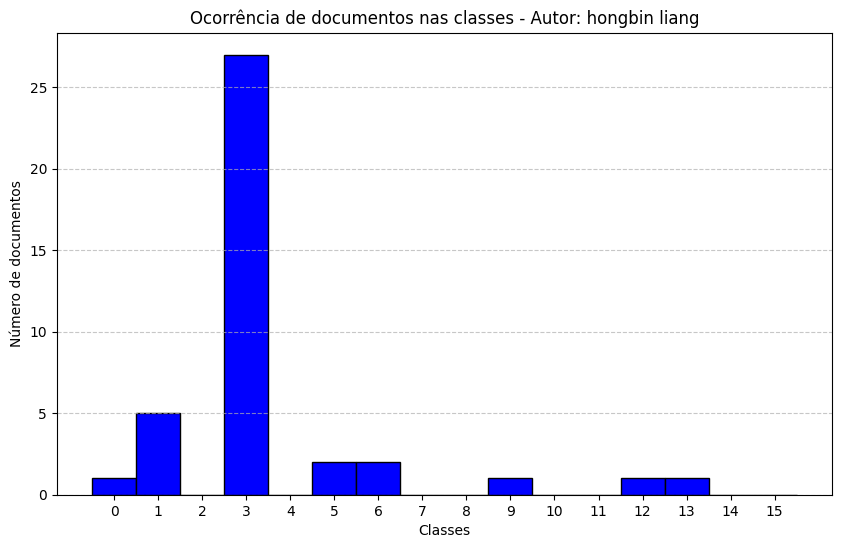

Relatórios de classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.83      1.00      0.91         5
           3       0.96      1.00      0.98        27
           5       0.50      1.00      0.67         2
           6       1.00      1.00      1.00         2
           9       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         1

    accuracy                           0.90        40
   macro avg       0.41      0.50      0.44        40
weighted avg       0.83      0.90      0.86        40

Accuracy on test data = 90.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def valid(model, testing_loader):
    model.eval()
    all_predictions = []
    all_targets = []
    tr_loss = 0

    num_classes = 16

    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()

            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate the accuracy
    accuracy = np.mean(np.array(all_predictions) == np.array(all_targets)) * 100

    # Print validation loss and accuracy
    epoch_loss = tr_loss / len(testing_loader)
    print(f"Validation Loss: {epoch_loss}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

    # Plot histogram of document occurrence in classes
    plt.figure(figsize=(10, 6))
    plt.hist(all_targets, bins=np.arange(num_classes+1)-0.5, color='blue', edgecolor='black', align='mid')
    plt.xlabel("Classes")
    plt.ylabel("Número de documentos")
    plt.title("Ocorrência de documentos nas classes - Autor: " + autor)
    plt.xticks(range(num_classes))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Plot other relevant graphs if needed

    # Print classification report
    print("Relatórios de classificação:")
    print(classification_report(all_targets, all_predictions))

    return accuracy

# Call the valid function after the training
print('Esta é a seção de validação para imprimir a acurácia e ver como está o desempenho')
print('Aqui estamos utilizando o carregador criado para o conjunto de dados de validação, a abordagem utiliza mais o PyTorch')


acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)


<a id='section07'></a>
### Salvando os Artefatos do Modelo Treinado para Inferência

Este é o último passo no processo de ajuste fino do modelo.

O modelo e seu vocabulário são salvos localmente. Esses arquivos são então usados no futuro para fazer inferências sobre novas entradas de manchetes de notícias.

Por favor, lembre-se de que uma rede neural treinada só é útil quando usada em inferência real após seu treinamento.

No ciclo de vida de projetos de aprendizado de máquina, isso é apenas metade do trabalho feito. Deixaremos a inferência desses modelos para outro dia.


In [ ]:
# Saving the files for re-use

output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

All files saved
This tutorial is completed
